In [1]:
!pip install -U xgboost

In [97]:
from IPython.display import display, Markdown

import pandas as pd
import numpy as np

import gc

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

# XGBoost
import xgboost as xgb

import itertools

In [10]:
import dask
import dask_xgboost
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split as train_test_split_da

In [ ]:
"""
Columns
The following columns are available on the training set:

ROW_ID Row of the submission file
TODO: conversion Target variable, it is True if this print has an attributed order

! accepts_mercadopago Whether the item accepts Mercado Pago

* available_quantity The available stock quantity at that moment

* avg_asp_item_bday Average selling price of this item over the last days
* avg_asp_item_domain Average price of items of the domain this item belongs to
! avg_asp_item_sel Average price of seller sales

! avg_gmv_item_bday average revenue generated by the item per day
? avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
? avg_gmv_item_sel Average revenue of items of this seller
? avg_gmv_seller_bday Average revenue this seller makes by day

? avg_orders_item_bday Average number of orders this item has by day
! avg_orders_seller_bday Average orders the seller has by day

! avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
! avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days

! avg_si_item_bday Average units sold this item has by day
! avg_si_item_sel_30day Average units sold of an item of this seller on the past month

avg_visits_item Average visits this item had

benefit Ignore, should be dropped
boosted Whether the item was boosted

! buy_server_timestamp Timestamp of the purchase

? category_id Category of this item

? cus_cust_id Buyer id
? cus_cust_id_sel Seller id

! date Print date
! deal_print_id Unique id for the print

! decimals Ignore, will be dropped

? domain_id Domain id for the item

! etl_version Ignore, should be dropped

* free_shipping Whether the item has free shipping
* fulfillment Whether the item is fulfilled by MeLi

! full_name Category full name

* health Item health

* is_pdp Whether the click landed on a PDP

? product_id Product_id of the item

! item_id ID of the item, useful for debugging

? listing_type_id Whether the item is gold or not

? logistic_type Logistic type for the item

! main_picture URL for the main item picture

* offset On which page the item was rendered

* original_price Price from which the discount was done

* platform Which platform the user is using

* price Item price

* print_position Position on the page
! print_server_timestamp Timestamp for the print

* qty_items_dom Number of items this domain has
* qty_items_sel Number of items the seller has

! rn Leftover from the ETL, Discard

? site_id Site ID

* sold_quantity Number of items sold at the moment of the print
? tags Tags the item had at the moment of the print
! title Item title

total_asp_item_domain_30days Average selling price of the items of the domain
! total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days

* total_gmv_domain_30days Total revenue the domain made on the last 30 days
! total_gmv_domain_bday total_gmv_domain_30days / 30
* total_gmv_item_30days Total revenue made by the item on the lasts 30 days
! total_gmv_seller Total revenue made by the seller on the last month

! total_items_domain Number of items on the domain
! total_items_seller Number of items the seller has

! total_orders_domain_30days Total orders on the domain
! total_orders_item_30days Total orders the Item had on the last 30 days
! total_orders_sel_30days Total orders for the seller

total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
! total_si_sel_30days Same for the seller

! total_visits_domain Total visits on this domain
! total_visits_item Total visits this item had
! total_visits_seller Total visits for this seller

! uid session id
! user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

In [163]:
def load_comp_dask():
    # Load the competition data
    comp_data = dd.read_csv("competition_data.csv",
        dtype={'offset': 'float64',
            'original_price': 'float64',
            'price': 'float64',
            'print_position': 'float64',
            'sold_quantity': 'float64',
            'total_items_domain': 'float64',
            'total_items_seller': 'float64',
            'total_visits_domain': 'float64',
            'total_visits_item': 'float64',
            'total_visits_seller': 'float64'}
    )
    comp_data = comp_data.drop(
        columns=[
            "benefit",
            "etl_version",
            "uid",
            "date",
            "deal_print_id",
            "full_name",
            "main_picture",
            "warranty",
            "tags",
            "print_server_timestamp",
            #"print_position",
            "title",
            "accepts_mercadopago",
            "category_id",
            "domain_id",
            "logistic_type",
            "platform",
            "site_id",
            "total_asp_item_sel_30days", 
            "total_gmv_domain_bday", 
            "total_gmv_seller", 
            "total_items_domain", 
            "total_items_seller", 
            "total_orders_domain_30days", 
            "total_orders_item_30days", 
            "total_orders_sel_30days", 
            "total_si_sel_30days", 
            "total_visits_domain", 
            "total_visits_item", 
            "total_visits_seller"
        ]
    )
    # OHE comp_data columns
    # comp_data = pd.get_dummies(comp_data,
    #     sparse=True,
    #     columns=[
    #         #"category_id",
    #         #"domain_id",
    #         "logistic_type",
    #         "platform",
    #         "site_id"
    #     ],
    #     dtype=int
    # )
    #comp_data["accepts_mercadopago"] = comp_data["accepts_mercadopago"].astype(int)
    # todos aceptan mercadopago
    comp_data["boosted"] = comp_data["boosted"].astype(int)
    comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
    comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

    comp_data["is_pdp"] = comp_data["is_pdp"].fillna(0).astype(float)
    #comp_data["warranty"] = comp_data["warranty"].astype(int)

    # comp_data["listing_type_id"] to 0 if gold_special, 1 if gold_pro.
    comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

    # Label encode category_id and domain_id
    # comp_data["category_id"] = comp_data["category_id"].astype("category")#.cat.codes
    #comp_data["domain_id"] = comp_data["domain_id"].astype("category")#.cat.codes

    # sklearn LabelEncoder for category_id and domain_id

    #comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    #comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    #comp_data["item_id"] = LabelEncoder().fit_transform(comp_data["item_id"]).astype(int)

    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["cheaper_than_original"] = comp_data["price_diff"].apply(lambda x: 1 if x < 0 else 0)
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    #comp_data["cheaper_than_avg"] = comp_data["price"] - comp_data["avg_asp_item_domain"]
    #comp_data["cheaper_than_avg"] = comp_data["cheaper_than_avg"].apply(lambda x: 1 if x < 0 else 0).astype(int)

    # Drop useless columns
    comp_data = comp_data.drop(
        columns=[
           "avg_asp_item_bday",
            "avg_asp_item_domain",
        ]
    )

    return comp_data

def train_test_dask():
  # Split into training and evaluation samples
  comp_data = load_comp()

  display(
      Markdown(
          "\n".join(
              [
                  #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                  "- **{}** ({})".format(col, dtype) for col, dtype in
                  zip(comp_data.columns, comp_data.dtypes)
              ]
          )
      )
  )

  full_data = comp_data[comp_data["ROW_ID"].isna()]
  eval_data = comp_data[~comp_data["ROW_ID"].isna()]

  # Get number column names for full_data
  #print(full_data.columns)
  #num_cols = full_data.select_dtypes(include='number').columns
  #print(num_cols)
  # difference between full_data_cols and num_cols
  # print(set(full_data.columns) - set(num_cols))

  del comp_data
  gc.collect()

  #train_data, test_data = train_test_split(full_data, test_size=0.20, train_size=0.80, random_state=42)
  train_data, test_data = train_test_split_da(full_data, test_size=0.20, train_size=0.80, random_state=42)

  # cut = full_data.shape[0] // 100 * 80
  # train_data = full_data.loc[:cut]
  # test_data = full_data.loc[cut:]

  y_train = train_data["conversion"]
  X_train = train_data.drop(columns=["conversion", "ROW_ID"])
  X_train = X_train.select_dtypes(include='number')

  y_test = test_data["conversion"]
  X_test = test_data.drop(columns=["conversion", "ROW_ID"])
  X_test = X_test.select_dtypes(include='number')

  del train_data
  del test_data

  gc.collect()

  return X_train, y_train, X_test, y_test

In [35]:
def load_comp():
    # Load the competition data
    comp_data = pd.read_csv("data/competition_data.csv")
    comp_data = comp_data.drop(
        columns=[
            "benefit",
            "etl_version",
            "uid",
            "date",
            "deal_print_id",
            "full_name",
            "main_picture",
            "warranty",
            "tags",
            "print_server_timestamp",
            #"print_position",
            "title",
            "accepts_mercadopago",
            "site_id",
            "product_id",
            "user_id",
        ]
    )
    # OHE comp_data columns
    comp_data = pd.get_dummies(comp_data,
        # sparse=True,
        columns=[
            # "category_id",
            # "domain_id",
            # "logistic_type",
            # "platform",
        ],
        dtype=int
    )
    #comp_data["accepts_mercadopago"] = comp_data["accepts_mercadopago"].astype(int)
    # todos aceptan mercadopago
    comp_data["boosted"] = comp_data["boosted"].astype(int)
    comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
    comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

    comp_data["is_pdp"].fillna(0, inplace=True)
    comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)
    #comp_data["warranty"] = comp_data["warranty"].astype(int)

    # comp_data["listing_type_id"] to 0 if gold_special, 1 if gold_pro.
    comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

    
    # Label encode category_id and domain_id
    # comp_data["category_id"] = comp_data["category_id"].astype("category")#.cat.codes
    #comp_data["domain_id"] = comp_data["domain_id"].astype("category")#.cat.codes

    # sklearn LabelEncoder for category_id and domain_id

    comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["item_id"] = LabelEncoder().fit_transform(comp_data["item_id"]).astype(int)

    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["cheaper_than_original"] = comp_data["price_diff"].apply(lambda x: 1 if x < 0 else 0)
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    """
    # Ratio Features:
    """
    
    # comp_data["ratio_sold_available"] = comp_data["sold_quantity"] / comp_data["available_quantity"]
    # Divide by zero error
    # if available_quantity is 0, then the item is sold out, so we can set the ratio to 1
    # comp_data["ratio_sold_available"] = comp_data["ratio_sold_available"].apply(lambda x: 1 if x == np.inf else x)

    #Price and Discount Features:

    #You could create a feature that represents the percentage discount offered for each item: (original_price - price) / original_price.
    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    # if original_price is 0, then the item is free, so we can set the discount to 1
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    #Another option could be to create a binary feature indicating whether an item is currently being sold at a discount compared to its original price.
    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    #Sales Velocity:

    #Combine the information from "sold_quantity" and "total_gmv_item_30days" to calculate a sales velocity feature, indicating how quickly an item is selling: sold_quantity / total_gmv_item_30days.
    # comp_data["sales_velocity"] = comp_data["sold_quantity"] / comp_data["total_gmv_item_30days"]
    # if total_gmv_item_30days is 0, then the item is not selling, so we can set the sales_velocity to 0
    # comp_data["sales_velocity"] = comp_data["sales_velocity"].apply(lambda x: 0 if x == np.inf else x)

    # Domain Performance Relative to Seller:

    # Calculate the ratio of "avg_gmv_item_domain_30days" to "avg_gmv_item_sel". This can show how an item's performance compares to its domain's average performance when looked at from the seller's perspective.

    comp_data["domain_performance"] = comp_data["avg_gmv_item_domain_30days"] / comp_data["avg_gmv_item_sel"]
    # if avg_gmv_item_sel is 0, then the seller is not selling, so we can set the domain_performance to 0
    comp_data["domain_performance"] = comp_data["domain_performance"].apply(lambda x: 0 if x == np.inf else x)

    # Categorical Combinations:

    # If "fulfillment" is related to how an item is fulfilled, you could combine it with "is_pdp" and "boosted" to create categorical combinations that capture more specific scenarios.
    comp_data["fulfillment_is_pdp_boosted"] = comp_data["fulfillment"].astype(str) + "_" + comp_data["is_pdp"].astype(str) + "_" + comp_data["boosted"].astype(str)
    comp_data["fulfillment_is_pdp_boosted"] = LabelEncoder().fit_transform(comp_data["fulfillment_is_pdp_boosted"]).astype(int)

    # comp_data["fulfillment_is_pdp_boosted"] = comp_data["fulfillment"] & comp_data["is_pdp"] & comp_data["boosted"]

    # Item Popularity:

    # Create a feature indicating whether an item's "sold_quantity" is above the average for its domain.

    # comp_data["sold_quantity_above_avg"] = comp_data["sold_quantity"] > comp_data["avg_si_item_domain_30days"]

    # Boolean Combinations:
    # Create features that capture combinations of boolean features. For example, combine "free_shipping" and "cheaper_than_original" to indicate if an item has free shipping and is cheaper than the original price.

    # comp_data["free_shipping_cheaper_than_original"] = comp_data["free_shipping"].astype(str) + "_" + comp_data["cheaper_than_original"].astype(str)
    # comp_data["free_shipping_cheaper_than_original"] = LabelEncoder().fit_transform(comp_data["free_shipping_cheaper_than_original"]).astype(int)

    comp_data["free_shipping_cheaper_than_original"] = comp_data["free_shipping"] & comp_data["cheaper_than_original"]

    comp_data = comp_data.drop(
        columns=[
            "category_id",
            "domain_id",
            "logistic_type",
            "platform",
            "sold_quantity"
        ]
    )

    # If starts with "total" drop column
    comp_data = comp_data.drop(
        columns=[
            col for col in comp_data.columns if col.startswith("total")
        ]
    )

    return comp_data


comp_data = load_comp()

display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                "- **{}** ({})".format(col, dtype) for col, dtype in
                zip(comp_data.columns, comp_data.dtypes)
            ]
        )
    )
)


del comp_data
gc.collect()

- **available_quantity** (int64)
- **avg_gmv_item_domain_30days** (float64)
- **avg_gmv_item_sel** (float64)
- **avg_gmv_seller_bday** (float64)
- **avg_qty_orders_item_domain_30days** (float64)
- **avg_qty_orders_item_sel_30days** (float64)
- **avg_si_item_sel_30day** (float64)
- **boosted** (int64)
- **conversion** (float64)
- **free_shipping** (int64)
- **fulfillment** (int64)
- **health** (float64)
- **is_pdp** (int64)
- **item_id** (int64)
- **listing_type_id** (int64)
- **offset** (int64)
- **original_price** (int64)
- **price** (int64)
- **print_position** (int64)
- **qty_items_dom** (float64)
- **qty_items_sel** (float64)
- **ROW_ID** (float64)
- **price_diff** (int64)
- **cheaper_than_original** (int64)
- **discount** (float64)
- **is_discount** (int64)
- **domain_performance** (float64)
- **fulfillment_is_pdp_boosted** (int64)
- **free_shipping_cheaper_than_original** (int64)

0

In [174]:
def load_comp():
    # Load the competition data
    comp_data = pd.read_csv("data/competition_data.csv")
    comp_data = comp_data.drop(
        columns=[
            "accepts_mercadopago",
            "avg_qty_orders_item_domain_30days",
            "avg_qty_orders_item_sel_30days",
            "avg_si_item_sel_30day",
            "date",
            "deal_print_id",
            "etl_version",
            "full_name",
            "main_picture",
            "print_server_timestamp",
            "title",
            "uid",
            "user_id",
            #"avg_gmv_item_domain_30days",
            #"avg_gmv_item_sel",
            "avg_gmv_seller_bday",
            #"category_id",
            "domain_id",
            "product_id",
            # "listing_type_id",
            "logistic_type",
            "site_id",
            "tags",
            #"total_asp_item_sel_30days", 
            #"total_gmv_domain_bday", 
            #"total_gmv_seller", 
            #"total_items_domain", 
            #"total_items_seller", 
            #"total_orders_domain_30days", 
            #"total_orders_item_30days", 
            #"total_orders_sel_30days", 
            #"total_si_sel_30days", 
            #"total_visits_domain", 
            #"total_visits_item", 
            #"total_visits_seller"
        ]
    )

    # Get all tags
    # tags = set()
    # for tag in comp_data["tags"]:
    #     if type(tag) == str:
    #         tags.update(tag.split("|"))
    
    # # Create a column for each tag
    # for tag in tags:
    #     comp_data["tag_"+tag] = comp_data["tags"].apply(lambda x: 1 if type(x) == str and tag in x else 0)

    # comp_data = comp_data.drop(columns=["tags"])

    comp_data["boosted"] = comp_data["boosted"].astype(int)
    comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
    comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

    comp_data["is_pdp"].fillna(0, inplace=True)
    comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)

    comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

    #comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    #comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["item_id"] = LabelEncoder().fit_transform(comp_data["item_id"]).astype(int)

    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["cheaper_than_original"] = comp_data["price_diff"].apply(lambda x: 1 if x < 0 else 0)
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    comp_data["domain_performance"] = comp_data["avg_gmv_item_domain_30days"] / comp_data["avg_gmv_item_sel"]
    comp_data["domain_performance"] = comp_data["domain_performance"].apply(lambda x: 0 if x == np.inf else x)

    comp_data["fulfillment_is_pdp_boosted"] = comp_data["fulfillment"].astype(str) + "_" + comp_data["is_pdp"].astype(str) + "_" + comp_data["boosted"].astype(str)
    comp_data["fulfillment_is_pdp_boosted"] = LabelEncoder().fit_transform(comp_data["fulfillment_is_pdp_boosted"]).astype(int)

    comp_data["free_shipping_cheaper_than_original"] = comp_data["free_shipping"] & comp_data["cheaper_than_original"]

    comp_data = comp_data.drop(
        columns=[
            col for col in comp_data.columns if col.startswith("total")
        ]
    )

    return comp_data


comp_data = load_comp()

display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                "- **{}** ({})".format(col, dtype) for col, dtype in
                zip(comp_data.columns, comp_data.dtypes)
            ]
        )
    )
)


del comp_data
gc.collect()

- **available_quantity** (int64)
- **avg_gmv_item_domain_30days** (float64)
- **avg_gmv_item_sel** (float64)
- **benefit** (float64)
- **boosted** (int64)
- **category_id** (object)
- **conversion** (float64)
- **free_shipping** (int64)
- **fulfillment** (int64)
- **health** (float64)
- **is_pdp** (int64)
- **item_id** (int64)
- **listing_type_id** (int64)
- **offset** (int64)
- **original_price** (int64)
- **platform** (object)
- **price** (int64)
- **print_position** (int64)
- **qty_items_dom** (float64)
- **qty_items_sel** (float64)
- **sold_quantity** (int64)
- **warranty** (object)
- **ROW_ID** (float64)
- **price_diff** (int64)
- **cheaper_than_original** (int64)
- **discount** (float64)
- **is_discount** (int64)
- **domain_performance** (float64)
- **fulfillment_is_pdp_boosted** (int64)
- **free_shipping_cheaper_than_original** (int64)

967

In [175]:
# Split into training and evaluation samples
comp_data = load_comp()

display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                "- **{}** ({})".format(col, dtype) for col, dtype in
                zip(comp_data.columns, comp_data.dtypes)
            ]
        )
    )
)

full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[~comp_data["ROW_ID"].isna()]

# Get number column names for full_data
#print(full_data.columns)
#num_cols = full_data.select_dtypes(include='number').columns
#print(num_cols)
# difference between full_data_cols and num_cols
# print(set(full_data.columns) - set(num_cols))

del comp_data
gc.collect()

# If col starts with avg..., if row has NaN, drop the row
full_data = full_data.dropna(axis=0, subset=[col for col in full_data.columns if col.startswith("avg")])
full_data = full_data.dropna(axis=0, subset=[col for col in full_data.columns if col.startswith("total")])

train_data, test_data = train_test_split(full_data, test_size=0.25, train_size=0.75)

y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')


y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

- **available_quantity** (int64)
- **avg_gmv_item_domain_30days** (float64)
- **avg_gmv_item_sel** (float64)
- **benefit** (float64)
- **boosted** (int64)
- **category_id** (object)
- **conversion** (float64)
- **free_shipping** (int64)
- **fulfillment** (int64)
- **health** (float64)
- **is_pdp** (int64)
- **item_id** (int64)
- **listing_type_id** (int64)
- **offset** (int64)
- **original_price** (int64)
- **platform** (object)
- **price** (int64)
- **print_position** (int64)
- **qty_items_dom** (float64)
- **qty_items_sel** (float64)
- **sold_quantity** (int64)
- **warranty** (object)
- **ROW_ID** (float64)
- **price_diff** (int64)
- **cheaper_than_original** (int64)
- **discount** (float64)
- **is_discount** (int64)
- **domain_performance** (float64)
- **fulfillment_is_pdp_boosted** (int64)
- **free_shipping_cheaper_than_original** (int64)

0

In [171]:
atributes_to_poly = [
                        "available_quantity",
                        "avg_gmv_item_domain_30days",
                        # "avg_gmv_item_sel",
                        # "avg_gmv_seller_bday",
                        # "avg_qty_orders_item_domain_30days",
                        # "avg_qty_orders_item_sel_30days",
                        # "avg_si_item_sel_30day",
                        "original_price",
                        "price",
                        "total_asp_item_domain_30days",
                        #"total_asp_item_sel_30days",
                        "offset",
                        "print_position",
                    ]

for col in atributes_to_poly:
    if col in X_train.columns:
        if X_train[col].isna().sum() > 0:
            atributes_to_poly.remove(col)
    else:
        atributes_to_poly.remove(col)
                    
pl = PolynomialFeatures(2, interaction_only=True, include_bias=False)

#Input X contains NaN.

imputed_X_train_plus = X_train.copy()
imputed_X_test_plus = X_test.copy()

# Make new columns indicating what will be imputed
cols_with_missing = (col for col in X_train.columns
                        if X_train[col].isnull().any() or X_train[col].isna().any())

for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()


poly_X_train = imputed_X_train_plus[atributes_to_poly]
poly_X_test = imputed_X_test_plus[atributes_to_poly]


#print(poly_X_train.shape[0] == X_train.shape[0])

poly_X_train = my_imputer.fit_transform(poly_X_train)
poly_X_test = my_imputer.transform(poly_X_test)

#print(poly_X_train.shape[0] == X_train.shape[0])

poly_X_train = pl.fit_transform(poly_X_train)
poly_X_test = pl.fit_transform(poly_X_test)
#print(poly_X_train.shape[0] == X_train.shape[0])

# add columns names to arrs
#poly_cols = ["_".join([a, b]) for a in atributes_to_poly for b in atributes_to_poly]
import itertools
poly_cols = ["_".join([a, b]) for a, b in itertools.combinations(atributes_to_poly, 2)]

poly_cols = atributes_to_poly + poly_cols

poly_X_train = pd.DataFrame(poly_X_train, columns=poly_cols)
poly_X_test = pd.DataFrame(poly_X_test, columns=poly_cols)

imputed_X_train_plus.drop(columns=atributes_to_poly, inplace=True)
imputed_X_test_plus.drop(columns=atributes_to_poly, inplace=True)

#new_X_train = pd.concat([imputed_X_train_plus, poly_X_train], axis=1).astype(float)
#new_X_test = pd.concat([imputed_X_test_plus, poly_X_test], axis=1).astype(float)

imputed_X_train_plus[poly_cols] = poly_X_train
imputed_X_test_plus[poly_cols] = poly_X_test

new_X_train = imputed_X_train_plus.astype(float)
new_X_test = imputed_X_test_plus.astype(float)

display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                "- **{}** ({})".format(col, dtype) for col, dtype in
                zip(new_X_train.columns, new_X_train.dtypes)
            ]
        )
    )
)

- **avg_gmv_item_sel** (float64)
- **benefit** (float64)
- **boosted** (float64)
- **free_shipping** (float64)
- **fulfillment** (float64)
- **health** (float64)
- **is_pdp** (float64)
- **item_id** (float64)
- **listing_type_id** (float64)
- **qty_items_dom** (float64)
- **qty_items_sel** (float64)
- **sold_quantity** (float64)
- **price_diff** (float64)
- **cheaper_than_original** (float64)
- **discount** (float64)
- **is_discount** (float64)
- **fulfillment_is_pdp_boosted** (float64)
- **free_shipping_cheaper_than_original** (float64)
- **benefit_was_missing** (float64)
- **available_quantity** (float64)
- **avg_gmv_item_domain_30days** (float64)
- **original_price** (float64)
- **price** (float64)
- **offset** (float64)
- **print_position** (float64)
- **available_quantity_avg_gmv_item_domain_30days** (float64)
- **available_quantity_original_price** (float64)
- **available_quantity_price** (float64)
- **available_quantity_offset** (float64)
- **available_quantity_print_position** (float64)
- **avg_gmv_item_domain_30days_original_price** (float64)
- **avg_gmv_item_domain_30days_price** (float64)
- **avg_gmv_item_domain_30days_offset** (float64)
- **avg_gmv_item_domain_30days_print_position** (float64)
- **original_price_price** (float64)
- **original_price_offset** (float64)
- **original_price_print_position** (float64)
- **price_offset** (float64)
- **price_print_position** (float64)
- **offset_print_position** (float64)

In [140]:
atributes_to_poly = [
                        "available_quantity",
                        "avg_gmv_item_domain_30days",
                        # "avg_gmv_item_sel",
                        # "avg_gmv_seller_bday",
                        # "avg_qty_orders_item_domain_30days",
                        # "avg_qty_orders_item_sel_30days",
                        # "avg_si_item_sel_30day",
                        "original_price",
                        "price",
                        "total_asp_item_domain_30days",
                        #"total_asp_item_sel_30days",
                        "offset",
                        "print_position",
                    ]

for col in atributes_to_poly:
    if col in X_train.columns:
        if X_train[col].isna().sum() > 0:
            atributes_to_poly.remove(col)
    else:
        atributes_to_poly.remove(col)

new_X_train = X_train.copy()
new_X_test = X_test.copy()

for a, b in itertools.combinations(atributes_to_poly, 2):
    new_X_train[a + "2" + b + "2"] = new_X_train[a] ** 2 + new_X_train[b] ** 2
    new_X_test[a + "2" + b + "2"] = new_X_test[a] ** 2 + new_X_test[b] ** 2

In [44]:
["_".join([a, b]) for a, b in set(itertools.product(atributes_to_poly, atributes_to_poly)) if a != b]

['available_quantity_price',
 'offset_avg_si_item_sel_30day',
 'avg_gmv_item_sel_available_quantity',
 'avg_gmv_item_sel_avg_qty_orders_item_domain_30days',
 'avg_gmv_item_domain_30days_avg_gmv_seller_bday',
 'avg_qty_orders_item_domain_30days_avg_si_item_sel_30day',
 'avg_gmv_item_domain_30days_avg_qty_orders_item_domain_30days',
 'avg_si_item_sel_30day_avg_gmv_item_sel',
 'price_avg_gmv_seller_bday',
 'avg_gmv_item_sel_avg_qty_orders_item_sel_30days',
 'avg_gmv_item_sel_print_position',
 'offset_price',
 'print_position_avg_gmv_item_sel',
 'available_quantity_avg_gmv_seller_bday',
 'avg_gmv_item_domain_30days_print_position',
 'avg_qty_orders_item_domain_30days_price',
 'avg_qty_orders_item_sel_30days_avg_gmv_seller_bday',
 'avg_gmv_item_domain_30days_original_price',
 'avg_gmv_item_sel_offset',
 'available_quantity_print_position',
 'price_original_price',
 'offset_avg_gmv_seller_bday',
 'avg_qty_orders_item_domain_30days_avg_gmv_seller_bday',
 'avg_qty_orders_item_domain_30days_ava

In [37]:
comp_data = load_comp()

In [34]:
comp_data["free_shipping_cheaper_than_original"].value_counts()

0    120063
1     79909
Name: free_shipping_cheaper_than_original, dtype: int64

In [38]:
comp_data["fulfillment_is_pdp_boosted"].value_counts()

0_0_0    150638
1_0_0     48682
1_1_0       400
0_1_0       252
Name: fulfillment_is_pdp_boosted, dtype: int64

In [ ]:
del comp_data
gc.collect()

In [140]:
# Count nans for each column
for col in X_train.columns:
    if X_train[col].isna().sum() > 0:
        print(col, X_train[col].isna().sum())

product_id 108476
user_id 15299


In [138]:
X_train.shape, y_train.shape

((141469, 61), (141469,))

In [7]:
X_test.shape, y_test.shape

((36153, 53), (36153,))

In [8]:
eval_data.shape

(19211, 55)

In [9]:
eval_data.shape[0] + X_train.shape[0] + X_test.shape[0]

199972

In [ ]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

In [ ]:
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

da_bst = dask_xgboost.train(client, params, data=X_train, labels=y_train, num_boost_round=10)

In [8]:
y_hat = dask_xgboost.predict(client, da_bst, X_test).persist()
y_hat

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [58]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

In [30]:
for col in atributes_to_poly:
    print(col, X_train[col].isna().sum())

available_quantity 0
avg_gmv_item_domain_30days 0
avg_gmv_item_sel 0
avg_gmv_seller_bday 0
avg_qty_orders_item_domain_30days 0
avg_qty_orders_item_sel_30days 0
avg_si_item_sel_30day 0
original_price 0
price 0
offset 0


In [31]:
# Get rows that have more NaNs
# new_X_train[new_X_train.isna().sum(axis=1) > 0]

# Count how many NaNs each row has
new_X_train[new_X_train.isna().sum(axis=1) > 0].isna().sum(axis=1).value_counts()

# For those rows that have exactly 78 columns with NaNs, what are the columns that have NaNs?
#set(new_X_train.columns[new_X_train[new_X_train.isna().sum(axis=1) == 78].isna().sum(axis=0) == 30654].tolist()) - set( ["_".join([a, b]) for a, b in itertools.combinations(atributes_to_poly, 2)])

55    30654
dtype: int64

In [193]:
new_X_train.shape

(141469, 123)

In [147]:
for col in X_train.columns:
    if X_train[col].isna().sum() > 0:
        print(col, X_train[col].isna().sum())

benefit 1


In [176]:
xgb_attrs = xgb.XGBClassifier(
    missing=np.nan,
    n_jobs=-1,
    #tree_method='gpu_hist',
)
xgb_attrs.fit(X_train, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test)[:, xgb_attrs.classes_ == 1])

0.7675062630109407

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

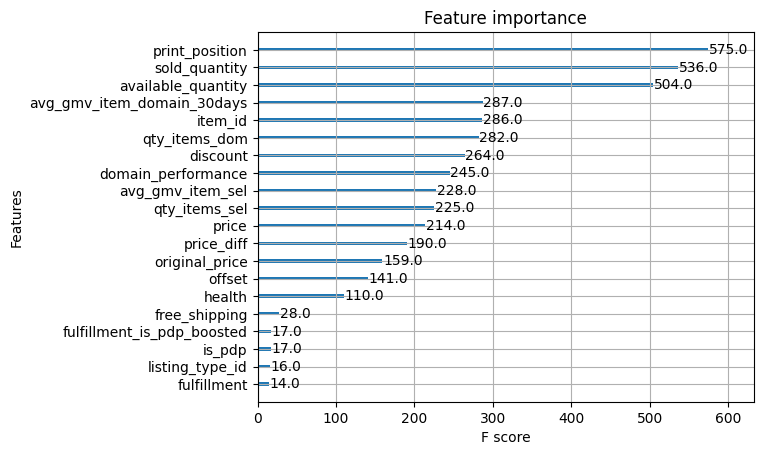

In [178]:
# Feature Importance
xgb.plot_importance(xgb_attrs, max_num_features=20)

In [179]:
# Get Feature Importance from the classifier xgb_attrs
feature_importances = pd.DataFrame(
    xgb_attrs.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
offset,0.120103
print_position,0.102764
is_pdp,0.086824
benefit,0.070341
free_shipping,0.058122
price,0.048884
fulfillment_is_pdp_boosted,0.045681
discount,0.042020
item_id,0.041581
avg_gmv_item_domain_30days,0.038223


In [142]:
xgb_attrs = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)
xgb_attrs.fit(X_train, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test)[:, xgb_attrs.classes_ == 1])

0.7712234999296064

In [100]:
from sklearn.impute import MissingIndicator

In [143]:
xgb_attrs = make_pipeline(
    SimpleImputer(strategy="mean"),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)

X_train_alt = X_train.copy()

og_cols = []
missing_cols = []

for col in X_train.columns:
    if X_train[col].isna().sum() > 0:
        X_train_alt[col + '_was_missing'] = X_train_alt[col].isnull()
        missing_cols.append(col + '_was_missing')
        og_cols.append(col)

X_test_alt = X_test.copy()
X_test_alt[missing_cols] = X_test_alt[og_cols].isnull()

xgb_attrs.fit(X_train_alt, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test_alt)[:, xgb_attrs.classes_ == 1])

0.7712230342131545

In [125]:
# SimpleImputer(meadian) + MissingIndicato

xgb_attrs = make_pipeline(
    SimpleImputer(strategy="mean"),
    PolynomialFeatures(2, interaction_only=True, include_bias=False),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)

X_train_alt = X_train.copy()

og_cols = []
missing_cols = []

for col in X_train.columns:
    if X_train[col].isna().sum() > 0:
        X_train_alt[col + '_was_missing'] = X_train_alt[col].isnull()
        missing_cols.append(col + '_was_missing')
        og_cols.append(col)

X_test_alt = X_test.copy()
X_test_alt[missing_cols] = X_test_alt[og_cols].isnull()

xgb_attrs.fit(X_train_alt, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test_alt)[:, xgb_attrs.classes_ == 1])

0.773474792599087

In [127]:
xgb_attrs = make_pipeline(
    SimpleImputer(strategy="mean"),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)

X_train_alt = new_X_train.copy()
X_test_alt = new_X_test.copy()

og_cols = []
missing_cols = []

for col in X_train.columns:
    if X_train[col].isna().sum() > 0:
        X_train_alt[col + '_was_missing'] = X_train_alt[col].isnull()
        missing_cols.append(col + '_was_missing')
        og_cols.append(col)

X_test_alt[missing_cols] = X_test_alt[og_cols].isnull()

xgb_attrs.fit(X_train_alt, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test_alt)[:, xgb_attrs.classes_ == 1])

0.7754268219088725

In [120]:
xgb_attrs = make_pipeline(
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
    )
)
xgb_attrs.fit(X_train, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test)[:, xgb_attrs.classes_ == 1])

0.7742722533960136

In [119]:
xgb_attrs = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
    )
)
xgb_attrs.fit(X_train, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test)[:, xgb_attrs.classes_ == 1])

0.774251853691113

In [98]:
xgb_attrs = make_pipeline(
    KNNImputer(),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)
xgb_attrs.fit(X_train, y_train)

roc_auc_score(y_test, xgb_attrs.predict_proba(X_test)[:, xgb_attrs.classes_ == 1])

KeyboardInterrupt: 

In [39]:
# Get Feature Importance from the classifier xgb_attrs
feature_importances = pd.DataFrame(
    xgb_attrs.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
offset,0.104055
print_position,0.101584
is_pdp,0.078321
fulfillment_is_pdp_boosted,0.058879
free_shipping,0.058779
price,0.042849
discount,0.039681
health,0.037876
original_price,0.035564
avg_qty_orders_item_sel_30days,0.035186


In [185]:
# KNNImputer
from sklearn.impute import KNNImputer

In [187]:
new_X_train

,boosted,category_id,domain_id,free_shipping,fulfillment,health,is_pdp,item_id,listing_type_id,qty_items_dom,...,original_price_price,original_price_total_asp_item_domain_30days,original_price_total_asp_item_sel_30days,original_price_offset,price_total_asp_item_domain_30days,price_total_asp_item_sel_30days,price_offset,total_asp_item_domain_30days_total_asp_item_sel_30days,total_asp_item_domain_30days_offset,total_asp_item_sel_30days_offset
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,465500.0,16882.612448,4925.080676,100800.0,16038.481826,4678.826642,95760.0,169.690262,3472.994561,1013.159453
1,0.0,611.0,1380.0,1.0,0.0,0.81,0.0,21439.0,0.0,25410.0,...,1664640.0,180745.380480,183115.019830,261120.0,162670.842432,164803.517847,235008.0,17894.244124,25516.994891,25851.532211
2,0.0,75.0,1147.0,0.0,1.0,0.80,0.0,11150.0,0.0,5259.0,...,3564090.0,53320.305040,52085.617180,382080.0,47988.274536,46877.055462,343872.0,701.300724,5144.471642,5025.345979
3,0.0,716.0,1578.0,1.0,1.0,1.00,0.0,27213.0,1.0,582.0,...,2497500.0,139661.102103,274183.067241,120000.0,55808.576401,109563.553669,47952.0,6126.833496,2681.493160,5264.314891
4,0.0,252.0,1274.0,0.0,0.0,0.81,0.0,3827.0,0.0,2495.0,...,14618910.0,322741.821764,457080.185923,0.0,268746.113636,380609.252669,0.0,8402.714264,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180756,0.0,486.0,7.0,1.0,0.0,0.90,0.0,22569.0,0.0,10310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180757,0.0,2177.0,1395.0,1.0,0.0,0.76,0.0,14658.0,0.0,3812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180758,0.0,62.0,1380.0,1.0,0.0,0.81,0.0,16963.0,0.0,31507.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180759,0.0,381.0,359.0,0.0,0.0,0.81,0.0,18345.0,1.0,1967.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
xgb2 = xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        eval_metric="auc",
        early_stopping_rounds=10,
        n_estimators=300,
    )

#X_train_, X_eval, y_train_, y_eval = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80)

#xgb2.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)])
# Pipeline.fit does not accept the eval_set parameter

kf = KFold(n_splits=5, shuffle=True)
rocs = []
for train_index, test_index in kf.split(X_train):
    X_train_, X_eval = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_eval = y_train.iloc[train_index], y_train.iloc[test_index]
    xgb2.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)])
    rocs.append(roc_auc_score(y_eval, xgb2.predict_proba(X_eval)[: , xgb2.classes_ == 1]))
    print(rocs[-1])

print(np.mean(rocs))

score = roc_auc_score(y_test, xgb2.predict_proba(X_test)[: , xgb2.classes_ == 1])
print(score)

# Get params from the classifier xgb2
print(xgb2.get_params())

# Get Feature Importance from the classifier xgb2
xgb2 = pd.DataFrame(
    xgb2.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

xgb2[xgb2["importance"] > 0]

[0]	validation_0-auc:0.71831
[1]	validation_0-auc:0.72474
[2]	validation_0-auc:0.72910
[3]	validation_0-auc:0.73132
[4]	validation_0-auc:0.73177
[5]	validation_0-auc:0.73440
[6]	validation_0-auc:0.73543
[7]	validation_0-auc:0.73615
[8]	validation_0-auc:0.73784
[9]	validation_0-auc:0.73975
[10]	validation_0-auc:0.74140
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.74196
[13]	validation_0-auc:0.74226
[14]	validation_0-auc:0.74374
[15]	validation_0-auc:0.74417
[16]	validation_0-auc:0.74451
[17]	validation_0-auc:0.74511
[18]	validation_0-auc:0.74570
[19]	validation_0-auc:0.74631
[20]	validation_0-auc:0.74662
[21]	validation_0-auc:0.74802
[22]	validation_0-auc:0.75007
[23]	validation_0-auc:0.75045
[24]	validation_0-auc:0.75082
[25]	validation_0-auc:0.75091
[26]	validation_0-auc:0.75126
[27]	validation_0-auc:0.75170
[28]	validation_0-auc:0.75165
[29]	validation_0-auc:0.75196
[30]	validation_0-auc:0.75217
[31]	validation_0-auc:0.75225
[32]	validation_0-auc:0.75226
[33]	validation_0-au

,importance
print_position,0.109617
offset,0.105051
free_shipping,0.076368
is_pdp,0.058683
fulfillment_is_pdp_boosted,0.056979
price,0.042522
discount,0.039023
avg_qty_orders_item_sel_30days,0.038382
original_price,0.036834
health,0.035614


In [85]:
imputed_poly_features = xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        eval_metric="auc",
        early_stopping_rounds=10,
        n_estimators=300,
    )

#X_train_, X_eval, y_train_, y_eval = train_test_split(new_X_train, y_train, test_size=0.20, train_size=0.80)

#imputed_poly_features.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)])
# Pipeline.fit does not accept the eval_set parameter

kf = KFold(n_splits=5, shuffle=True)
rocs = []
for train_index, test_index in kf.split(new_X_train):
    X_train_, X_eval = new_X_train.iloc[train_index], new_X_train.iloc[test_index]
    y_train_, y_eval = y_train.iloc[train_index], y_train.iloc[test_index]
    imputed_poly_features.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)])
    rocs.append(roc_auc_score(y_eval, imputed_poly_features.predict_proba(X_eval)[: , imputed_poly_features.classes_ == 1]))
    print(rocs[-1])

print(np.mean(rocs))

score = roc_auc_score(y_test, imputed_poly_features.predict_proba(new_X_test)[: , imputed_poly_features.classes_ == 1])
print(score)

# Get params from the classifier imputed_poly_features
print(imputed_poly_features.get_params())

# Get Feature Importance from the classifier imputed_poly_features
imputed_poly_features = pd.DataFrame(
    imputed_poly_features.feature_importances_,
    index = new_X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

imputed_poly_features[imputed_poly_features["importance"] > 0]

[0]	validation_0-auc:0.60970
[1]	validation_0-auc:0.63132
[2]	validation_0-auc:0.63553
[3]	validation_0-auc:0.64409
[4]	validation_0-auc:0.64949
[5]	validation_0-auc:0.65450
[6]	validation_0-auc:0.66422
[7]	validation_0-auc:0.66739
[8]	validation_0-auc:0.66922
[9]	validation_0-auc:0.67164
[10]	validation_0-auc:0.67585
[11]	validation_0-auc:0.68122
[12]	validation_0-auc:0.68332
[13]	validation_0-auc:0.68379
[14]	validation_0-auc:0.68508
[15]	validation_0-auc:0.68438
[16]	validation_0-auc:0.68787
[17]	validation_0-auc:0.68779
[18]	validation_0-auc:0.68721
[19]	validation_0-auc:0.69004
[20]	validation_0-auc:0.69124
[21]	validation_0-auc:0.69105
[22]	validation_0-auc:0.69050
[23]	validation_0-auc:0.69181
[24]	validation_0-auc:0.69190
[25]	validation_0-auc:0.69217
[26]	validation_0-auc:0.69168
[27]	validation_0-auc:0.69190
[28]	validation_0-auc:0.69263
[29]	validation_0-auc:0.69431
[30]	validation_0-auc:0.69279
[31]	validation_0-auc:0.69237
[32]	validation_0-auc:0.69150
[33]	validation_0-au

,importance
fulfillment_is_pdp_boosted,0.042584
fulfillment,0.037571
is_pdp,0.034739
free_shipping,0.033947
discount,0.028471
...,...
print_position,0.007073
available_quantity,0.006773
available_quantity_avg_gmv_item_sel,0.006349
avg_gmv_item_sel_original_price,0.005940


In [173]:
# XGBoost with Hyperopt

xgb_space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
    "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

X_train_, X_eval, y_train_, y_eval = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80, random_state=42)

# best_score = 0
def objective_xgb(params):
    # global best_score

    #kf = KFold(n_splits=10, shuffle=True)

    model =  make_pipeline(
        #SimpleImputer(),
        xgb.XGBClassifier(
            **params,
            missing=np.nan,
            n_jobs=-1,
        )
    )

    model.fit(X_train_, y_train_)

    score = roc_auc_score(y_eval, model.predict_proba(X_eval)[:, model.classes_ == 1])

    print(f"Score: {score}", params)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_xgb = Trials()

best_xgb_poly = fmin(
    fn=objective_xgb,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_xgb,
    verbose=2,
)

print(best_xgb_poly)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Score: 0.7498139608547651                              
{'colsample_bytree': 0.7751376397631812, 'gamma': 0.6528368137035083, 'learning_rate': 0.036008927007739444, 'max_depth': 4, 'min_child_weight': 64, 'n_estimators': 500, 'subsample': 0.6875212846187819}
Score: 0.743693311679428                                                          
{'colsample_bytree': 0.7893832946575405, 'gamma': 0.7082610107056653, 'learning_rate': 0.1868002425620968, 'max_depth': 16, 'min_child_weight': 4, 'n_estimators': 10, 'subsample': 0.6422037324509962}
Score: 0.7557927139241435                                                         
{'colsample_bytree': 0.923603015761616, 'gamma': 0.0024659474157395778, 'learning_rate': 0.13022133457483184, 'max_depth': None, 'min_child_weight': 128, 'n_estimators': 200, 'subsample': 0.8920497470711166}
Score: 0.7522953380236599                                                         
{'colsample_bytree': 0.6356177824920151, 'gamma': 0.39782965475283716, 'learning_rat

KeyboardInterrupt: 

In [89]:
# XGBoost with Hyperopt

xgb_space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
    "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

X_train_, X_eval, y_train_, y_eval = train_test_split(new_X_train, y_train, test_size=0.20, train_size=0.80, random_state=42)

# best_score = 0
def objective_xgb2(params):
    # global best_score

    #kf = KFold(n_splits=10, shuffle=True)

    xgb2 = xgb.XGBClassifier(
        **params,
        missing=np.nan,
        n_jobs=-1,
        eval_metric="auc",
        early_stopping_rounds=10,
    )

    #X_train_, X_eval, y_train_, y_eval = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80)

    #xgb2.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)])
    # Pipeline.fit does not accept the eval_set parameter

    kf = KFold(n_splits=5, shuffle=True)
    rocs = []
    for train_index, test_index in kf.split(X_train):
        X_train_, X_eval = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_eval = y_train.iloc[train_index], y_train.iloc[test_index]
        xgb2.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)], verbose=False)
        rocs.append(roc_auc_score(y_eval, xgb2.predict_proba(X_eval)[: , xgb2.classes_ == 1]))
        print(rocs[-1])

    score = np.mean(rocs)

    print(f"Score: {score}", params)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_xgb = Trials()

best_xgb2 = fmin(
    fn=objective_xgb2,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_xgb,
    verbose=2,
)

print(best_xgb2)

0.7524388494487675                                     
0.7530805311026888                                     
0.7551418825206421                                     
0.755246289680466                                      
0.7628427285521229                                     
Score: 0.7557500562609374                              
{'colsample_bytree': 0.842793829481435, 'gamma': 0.02988566712381502, 'learning_rate': 0.11249768474984939, 'max_depth': 64, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6697054532355113}
0.7625400108304418                                                                 
0.7608070160943101                                                                 
0.7600734942725851                                                                 
0.7658548787108362                                                                 
0.7494952194548068                                                                 
Score: 0.759754123872596                  

KeyboardInterrupt: 

In [206]:
# Get Feature Importance from the classifier imputed_poly_features

booster = imputed_poly_features.named_steps['xgbclassifier']
feature_importances = pd.DataFrame(
    booster.feature_importances_,
    index = new_X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances[feature_importances["importance"] > 0]

,importance
total_orders_item_30days,0.063161
platform_/web/desktop,0.024858
is_pdp,0.020721
total_visits_item,0.020676
logistic_type_not_specified,0.016310
...,...
price,0.005388
avg_gmv_item_domain_30days_original_price,0.005295
avg_si_item_sel_30day_price,0.005267
logistic_type_xd_drop_off,0.005008


In [71]:
scores_wo = {}

for col in X_train.columns[50:]:
    # Train without col
    model = xgb.XGBClassifier(missing=np.nan, n_jobs=-1)
    model.fit(X_train.drop(col, axis=1), y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test.drop(col, axis=1))[:, model.classes_ == 1])
    scores_wo[col] = score
    print(col, score)

scores_wo

site_id_MLA 1.0
price_diff 1.0
cheaper_than_original 1.0
ratio_sold_available 1.0
discount 1.0
is_discount 1.0
sales_velocity 1.0
conversion_rate 0.7879403308627391
domain_performance 1.0
free_shipping_cheaper_than_original 1.0


{'site_id_MLA': 1.0,
 'price_diff': 1.0,
 'cheaper_than_original': 1.0,
 'ratio_sold_available': 1.0,
 'discount': 1.0,
 'is_discount': 1.0,
 'sales_velocity': 1.0,
 'conversion_rate': 0.7879403308627391,
 'domain_performance': 1.0,
 'free_shipping_cheaper_than_original': 1.0}

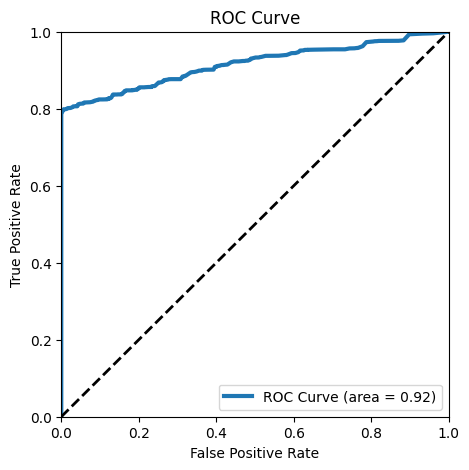

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(y_test, imputed_poly_features.predict_proba(new_X_test)[:, imputed_poly_features.classes_ == 1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

def plot_roc_curve(model, X, y, label=None):
    fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, model.classes_ == 1])
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [48]:
imputed_poly_features_kf = xgb.XGBClassifier(
    missing=np.nan,
    n_jobs=-1,
    #tree_method='gpu_hist',
)
#imputed_poly_features.fit(new_X_train, y_train)
#roc_auc_score(y_test, imputed_poly_features.predict_proba(new_X_test)[:, imputed_poly_features.classes_ == 1])

kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(imputed_poly_features_kf, new_X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1)
cv_scores, cv_scores.mean()

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 1.0)

In [66]:
imputed_poly_features_ss = make_pipeline(
    StandardScaler(),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
    )
)

imputed_poly_features_ss.fit(new_X_train, y_train)

roc_auc_score(y_test, imputed_poly_features_ss.predict_proba(new_X_test)[:, imputed_poly_features_ss.classes_ == 1])

1.0

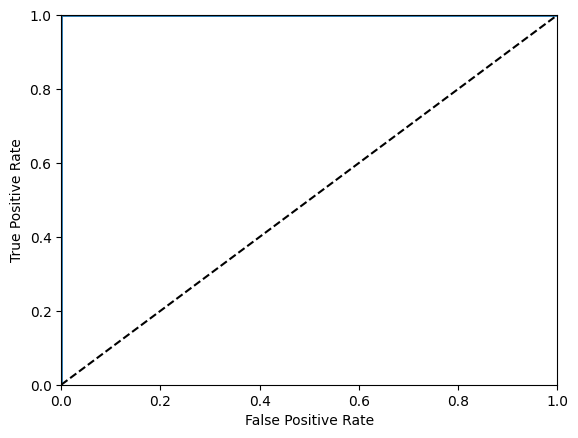

In [67]:
plot_roc_curve(imputed_poly_features_ss, new_X_test, y_test)

In [15]:
xgb_ss = make_pipeline(
    StandardScaler(),
    xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)
xgb_ss.fit(new_X_train, y_train)

roc_auc_score(y_test, xgb_ss.predict_proba(new_X_test)[:, xgb_ss.classes_ == 1])

0.7887609113539706

In [19]:
xgb_si = make_pipeline(
    SimpleImputer(),
    xgb.XGBClassifier(
        #missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)
xgb_si.fit(new_X_train, y_train)

roc_auc_score(y_test, xgb_si.predict_proba(new_X_test)[:, xgb_si.classes_ == 1])

0.7918859623632327

In [194]:
xgb_ss_si = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    xgb.XGBClassifier(
        #missing=np.nan,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )
)
xgb_ss_si.fit(X_train, y_train)

roc_auc_score(y_test, xgb_ss_si.predict_proba(X_test)[:, xgb_ss_si.classes_ == 1])

0.7675061369937184

In [15]:
# XGBoost with Hyperopt

xgb_space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
    "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

X_train_, X_eval, y_train_, y_eval = train_test_split(new_X_train, y_train, test_size=0.20, train_size=0.80, random_state=42)

# best_score = 0
def objective_xgb(params):
    # global best_score

    #kf = KFold(n_splits=10, shuffle=True)

    model =  xgb.XGBClassifier(
        **params,
        #early_stopping_rounds=10,
        #eval_metric="auc",
        n_jobs=-1,
        tree_method='gpu_hist',
    )

    #score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()

    #model.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)], verbose=False)
    #model.fit(new_X_train, y_train)
    model.fit(X_train_, y_train_)

    score = roc_auc_score(y_eval, model.predict_proba(X_eval)[:, model.classes_ == 1])

    print(f"Score: {score}", params)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_xgb = Trials()

best_xgb_poly = fmin(
    fn=objective_xgb,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_xgb,
    verbose=2,
)

print(best_xgb_poly)

Score: 0.7724855071630657
{'colsample_bytree': 0.644262948050691, 'gamma': 0.6305654937747499, 'learning_rate': 0.14821028221540827, 'max_depth': 128, 'min_child_weight': 8, 'n_estimators': 10, 'subsample': 0.8486542728975341}
Score: 0.7678423046311655
{'colsample_bytree': 0.5026158107243381, 'gamma': 0.32576220187078775, 'learning_rate': 0.1853178342782967, 'max_depth': 32, 'min_child_weight': 8, 'n_estimators': 200, 'subsample': 0.8900698030905325}
Score: 0.7306643908877529
{'colsample_bytree': 0.8794561387958301, 'gamma': 0.8726305851295316, 'learning_rate': 0.024660597203565008, 'max_depth': 2, 'min_child_weight': 64, 'n_estimators': 50, 'subsample': 0.8135558962487286}
Score: 0.78746802707215
{'colsample_bytree': 0.9337494145752561, 'gamma': 0.37112185693068966, 'learning_rate': 0.09721902008580376, 'max_depth': 16, 'min_child_weight': 16, 'n_estimators': 50, 'subsample': 0.6624152214018347}
Score: 0.7886805426502494
{'colsample_bytree': 0.7533016878142117, 'gamma': 0.443246656494

In [13]:
xgb_poly_params = {'colsample_bytree': 0.6376176334467911, 'gamma': 0.9666028107574587, 'learning_rate': 0.03800941131775906, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 4, 'subsample': 0.7163337577697995}
imputed_poly_features = make_pipeline(
    StandardScaler(),
    xgb.XGBClassifier(
      **xgb_poly_params,
      missing=np.nan,
      n_jobs=-1,
      #tree_method='gpu_hist',
  )
)
imputed_poly_features.fit(new_X_train, y_train)

roc_auc_score(y_test, imputed_poly_features.predict_proba(new_X_test)[:, imputed_poly_features.classes_ == 1])

0.7501474940877317

In [62]:
hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
)

hyper_rfs.fit(X_train, y_train)

roc_auc_score(y_test, hyper_rfs.predict_proba(X_test)[:, hyper_rfs.classes_ == 1])

1.0

In [ ]:
# Decision Tree Classifier with K-Fold Cross Validation and Randomized Search CV

dtc = make_pipeline(
    SimpleImputer(),
    RandomizedSearchCV(
        DecisionTreeClassifier(random_state=2345),
        param_distributions={
            "max_depth": [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64, 128, 256, 512],
            "min_samples_leaf": [2, 4, 8, 16, 32, 64, 128, 256, 512],
            "max_features": [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
        },
        n_iter=100,
        cv=3,
        random_state=2345,
        n_jobs=-1,
        verbose=0,
    )
)

kf = KFold(n_splits=5, random_state=2345, shuffle=True)
roc_aucs = []

for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    dtc.fit(X_train_kf, y_train_kf)
    # Metric: roc_auc_score
    roc_aucs.append(roc_auc_score(y_valid_kf, dtc.predict_proba(X_valid_kf)[:, dtc.classes_ == 1]))
    print(f"ROC-AUC split {len(roc_aucs)}: ", roc_aucs[-1])

print("ROC-AUC mean: ", sum(roc_aucs) / len(roc_aucs))

dtc.fit(X_train, y_train)

print("ROC-AUC: ", roc_auc_score(y_test, dtc.predict_proba(X_test)[:, dtc.classes_ == 1]))

In [ ]:
pd.Series(roc_aucs).describe()

count    5.000000
mean     0.719648
std      0.005229
min      0.714328
25%      0.715559
50%      0.717973
75%      0.724961
max      0.725421
dtype: float64

In [187]:
rf = make_pipeline(
    SimpleImputer(strategy="mean"), 
    RandomForestClassifier()
)
rf.fit(X_train, y_train)

roc_auc_score(y_test, rf.predict_proba(X_test)[:, rf.classes_ == 1])

0.6956091801242109

In [188]:
rfs = make_pipeline(
    SimpleImputer(),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=2345),
        param_distributions={
            "max_depth": [2, 4, 8, 16, 32, 64, 128, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64, 128],
            "min_samples_leaf": [2, 4, 8, 16, 32, 64, 128],
            "max_features": [2, 4, 8, 16, 32, 64, 128, None],
        },
        n_iter=100,
        cv=3,
        random_state=2345,
        n_jobs=-1,
        verbose=2,
    )
)

rfs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=32, max_features=2, min_samples_leaf=32, min_samples_split=16; total time=  11.5s
[CV] END max_depth=32, max_features=2, min_samples_leaf=32, min_samples_split=16; total time=  12.1s
[CV] END max_depth=32, max_features=2, min_samples_leaf=32, min_samples_split=16; total time=  12.6s
[CV] END max_depth=2, max_features=64, min_samples_leaf=4, min_samples_split=32; total time=  18.6s
[CV] END max_depth=2, max_features=64, min_samples_leaf=4, min_samples_split=32; total time=  19.2s
[CV] END max_depth=2, max_features=64, min_samples_leaf=4, min_samples_split=32; total time=  17.5s
[CV] END max_depth=4, max_features=64, min_samples_leaf=8, min_samples_split=128; total time=  34.2s
[CV] END max_depth=None, max_features=16, min_samples_leaf=128, min_samples_split=16; total time=  54.5s
[CV] END max_depth=None, max_features=16, min_samples_leaf=128, min_samples_split=16; total time=  55.1s
[CV] END max_depth=None

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3,
                                    estimator=RandomForestClassifier(random_state=2345),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'max_depth': [2, 4, 8,
                                                                       16, 32,
                                                                       64, 128,
                                                                       None],
                                                         'max_features': [2, 4,
                                                                          8, 16,
                                                                          32,
                                                                          64,
                                                                          128,
                                                                          None],
                                                         'min_samples_leaf': [2,
                                                                              4,
                                                                              8,
                                                                              16,
                                                                              32,
                                                                              64,
                                                                              128],
                                                         'min_samples_split': [2,
                                                                               4,
                                                                               8,
                                                                               16,
                                                                               32,
                                                                               64,
                                                                               128]},
                                    random_state=2345, verbose=2))])

In [191]:
rfs.steps[1][1].best_params_

{'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 128,
 'max_depth': 8}

In [189]:
roc_auc_score(y_test, rfs.predict_proba(X_test)[:, rfs.classes_ == 1])

0.7483323435880688

In [ ]:
space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, 256, 512, None]),
    "min_samples_split": hp.choice("min_samples_split", [2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "min_samples_leaf": hp.choice("min_samples_leaf", [2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "max_features": hp.choice("max_features", [2, 4, 8, 16, 32, 64, 128, 256, 512, None]),
}

def objective_dct(params):

    kf = KFold(n_splits=10, shuffle=True)

    model = make_pipeline(
        SimpleImputer(),
        DecisionTreeClassifier(**params),
    )

    score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
    # model.fit(X_train, y_train)

    # y_pred = model.predict_proba(X_test)[:, model.classes_ == 1]
    # score = roc_auc_score(y_test, y_pred)

    return {"loss": 1 - score, "status": STATUS_OK}


trials_dct = Trials()

best_dct = fmin(
    fn=objective_dct,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_dct,
)

print(best_dct)

100%|██████████| 100/100 [09:50<00:00,  5.90s/trial, best loss: 0.26513219216768746]
{'max_depth': 2, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 8}


In [ ]:
#best_dct = {'max_depth': 2, 'max_features': 6, 'min_samples_leaf': 6, 'min_samples_split': 6}

hyper_dct = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(**best_dct)
)

hyper_dct.fit(X_train, y_train)

# kf = KFold(n_splits=10, random_state=2345, shuffle=True)
# roc_auc_scores_hdct = []

# for train_index, valid_index in kf.split(X_train):

#     X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
#     y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

#     hyper_dct.fit(X_train_kf, y_train_kf)
#     # Metric: roc_auc_score
#     roc_auc_scores_hdct.append(roc_auc_score(y_valid_kf, hyper_dct.predict_proba(X_valid_kf)[:, hyper_dct.classes_ == 1]))
#     print(f"ROC-AUC split {len(roc_auc_scores_hdct)}: ", roc_auc_scores_hdct[-1])

print("ROC-AUC: ", roc_auc_score(y_test, hyper_dct.predict_proba(X_test)[:, hyper_dct.classes_ == 1]))

ROC-AUC:  0.6579065690644064


In [ ]:
hyper_dct.named_steps["decisiontreeclassifier"]

DecisionTreeClassifier(max_depth=2, max_features=5, min_samples_leaf=6,
                       min_samples_split=8)

[Text(0.5, 0.8333333333333334, 'total_visits_item <= 3133.5\ngini = 0.167\nsamples = 162684\nvalue = [147685, 14999]'),
 Text(0.25, 0.5, 'total_gmv_item_30days <= 270.81\ngini = 0.115\nsamples = 106254\nvalue = [99757, 6497]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.089\nsamples = 52476\nvalue = [50015, 2461]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.139\nsamples = 53778\nvalue = [49742, 4036]'),
 Text(0.75, 0.5, 'total_gmv_item_30days <= 3918.475\ngini = 0.256\nsamples = 56430\nvalue = [47928, 8502]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.214\nsamples = 33062\nvalue = [29031, 4031]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.309\nsamples = 23368\nvalue = [18897, 4471]')]

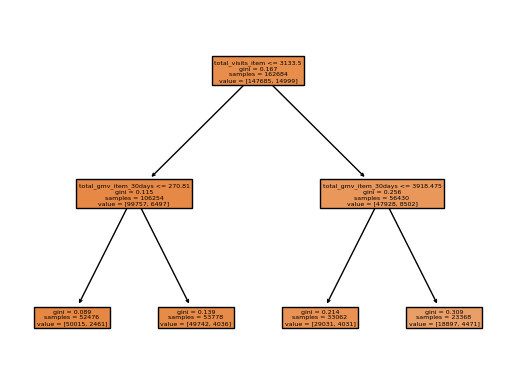

In [ ]:
plot_tree(hyper_dct.named_steps["decisiontreeclassifier"], max_depth=2, filled=True, feature_names=list(X_train.columns))

In [ ]:
space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "min_samples_split": hp.choice("min_samples_split", [2, 4, 8, 16, 32, 64, 128]),
    "min_samples_leaf": hp.choice("min_samples_leaf", [2, 4, 8, 16, 32, 64, 128]),
    "max_features": hp.choice("max_features", [2, 4, 8, 16, 32, 64, 128, None]),
}

def objective_rfs(params):
    model = make_pipeline(
        SimpleImputer(),
        RandomForestClassifier(**params, n_estimators=100, n_jobs=-1),
    )

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, model.classes_ == 1]
    score = roc_auc_score(y_test, y_pred)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_rfs = Trials()

best_rfs = fmin(
    fn=objective_rfs,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_rfs,
)

print(best_rfs)

100%|██████████| 100/100 [38:51<00:00, 23.32s/trial, best loss: 0.2121955631253214] 
{'max_depth': 3, 'max_features': 0, 'min_samples_leaf': 2, 'min_samples_split': 0}


In [ ]:
best_rfs["max_features"] = 1
best_rfs["min_samples_split"] = 2

best_rfs

{'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [ ]:
hyper_rfs_kf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

kf = KFold(n_splits=10, random_state=2345, shuffle=True)

roc_auc_scores_hrfs = []

for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    hyper_rfs_kf.fit(X_train_kf, y_train_kf)
    # Metric: roc_auc_score
    roc_auc_scores_hrfs.append(roc_auc_score(y_valid_kf, hyper_rfs_kf.predict_proba(X_valid_kf)[:, hyper_rfs_kf.classes_ == 1]))
    print(f"ROC-AUC split {len(roc_auc_scores_hrfs)}: ", roc_auc_scores_hrfs[-1])

print("ROC-AUC: ", roc_auc_score(y_test, hyper_rfs_kf.predict_proba(X_test)[:, hyper_rfs_kf.classes_ == 1]))

ROC-AUC split 1:  0.7081469103022364
ROC-AUC split 2:  0.7180935208870816
ROC-AUC split 3:  0.7089286667318965
ROC-AUC split 4:  0.7101126956253258
ROC-AUC split 5:  0.7035800560823728
ROC-AUC split 6:  0.7119053126906797
ROC-AUC split 7:  0.7110893194102677
ROC-AUC split 8:  0.7074769409294601
ROC-AUC split 9:  0.7048135724185971
ROC-AUC split 10:  0.7231767164494025
ROC-AUC:  0.721804311959505


In [ ]:
best_rfs = {
    'max_depth': 3,
    'max_features': 1,
    'min_samples_leaf': 2,
    'min_samples_split': 2
}

hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

hyper_rfs.fit(X_train, y_train)

roc_auc_score(y_test, hyper_rfs.predict_proba(X_test)[:, hyper_rfs.classes_ == 1])

0.7142635583841591

In [ ]:
y_preds_cls = dtc.predict_proba(X_test)[:, dtc.classes_ == 1].squeeze()
roc_auc_score(y_test, y_preds_cls)

0.6994391273622476

In [ ]:
#cls.score(X_validation, y_validation)

y_preds_rfs = rfs.predict_proba(X_test)[:, rfs.classes_ == 1].squeeze()
roc_auc_score(y_test, y_preds_rfs)

0.729350839606164

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
)

#xgb_model.fit(X_train, y_train)
#roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(xgb_model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1, verbose=2).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
xgb.set_config(verbosity=1)

In [ ]:
# Pandas hide UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# XGBoost with Hyperopt

warnings.filterwarnings("ignore", category=UserWarning)

xgb_space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
    "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

X_train_, X_eval, y_train_, y_eval = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80, random_state=42)

# best_score = 0
def objective_xgb(params):
    # global best_score

    #kf = KFold(n_splits=10, shuffle=True)

    model =  xgb.XGBClassifier(
        **params,
        early_stopping_rounds=10,
        eval_metric="auc",
    )

    #score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()


    model.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)], verbose=False)

    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

    print(f"Score: {score}", params)

    # if score > best_score:
        # best_score = score
        # print(f"New best score: {best_score}")
        # print(params)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_xgb = Trials()

best_xgb = fmin(
    fn=objective_xgb,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_xgb,
    verbose=2,
)

print(best_xgb)

Score: 0.7835950626541037                              
{'colsample_bytree': 0.9865558697264714, 'gamma': 0.12929172488084684, 'learning_rate': 0.13214872804415695, 'max_depth': 4, 'min_child_weight': 64, 'n_estimators': 200, 'subsample': 0.5444889526426269}
Score: 0.790444423930476                                                          
{'colsample_bytree': 0.8378308377556504, 'gamma': 0.15657840294680325, 'learning_rate': 0.090944395149636, 'max_depth': 64, 'min_child_weight': 32, 'n_estimators': 200, 'subsample': 0.9100842750536129}
Score: 0.786913381471421                                                          
{'colsample_bytree': 0.7701622227291531, 'gamma': 0.9080241945183694, 'learning_rate': 0.0848206061070631, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.7093527339303067}
Score: 0.7857134122233864                                                         
{'colsample_bytree': 0.9204395835391892, 'gamma': 0.21033686310911281, 'learning_rate': 0.

In [ ]:
# best_xgb = {'colsample_bytree': 0.6278514796444425,
#  'learning_rate': 0.07068021279873352,
#  'max_depth': 7,
#  'n_estimators': 4,
#  'subsample': 0.763643037745022}

best_xgb

{'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
)

#xgb_model.fit(X_train, y_train)
#roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(xgb_model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1, verbose=2).mean()

In [ ]:
params = {
    'colsample_bytree': 0.6278514796444425,
    'learning_rate': 0.07068021279873352,
    'max_depth': 7,
    'n_estimators': 4,
    'subsample': 0.763643037745022
}

xgb_kf = make_pipeline(
    #SimpleImputer(),
    xgb.XGBClassifier(
        **params,
        missing=-999,
        n_jobs=-1,
    )
)

#xgb_kf.fit(X_train, y_train, verbose = True)
#roc_auc_score(y_test, xgb_kf.predict_proba(X_test)[:, xgb_kf.classes_ == 1])

kf = KFold(n_splits=10, shuffle=True)

cross_val_score(
    xgb_kf,
    X_train, y_train,
    scoring="roc_auc",
    cv=KFold(n_splits=10, shuffle=True),
    n_jobs=-1,
    verbose=10
).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.753) total time=   3.7s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.761) total time=   4.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.1s remaining:    2.6s


[CV] END ................................ score: (test=0.747) total time=   4.2s
[CV] END ................................ score: (test=0.745) total time=   4.1s
[CV] END ................................ score: (test=0.751) total time=   4.2s
[CV] END ................................ score: (test=0.746) total time=   2.7s
[CV] END ................................ score: (test=0.752) total time=   2.6s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished


0.751205010063007

In [ ]:
params_colab1 = {
  'colsample_bytree': 0.8337751225603421,
 'gamma': 0.869242256759736,
 'learning_rate': 0.1452990294484685,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 4,
 'subsample': 0.850647916320707
}

hyper_xgb_colab1 = xgb.XGBClassifier(
        **params_colab1,
        missing=-999,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )

hyper_xgb_colab1.fit(X_train, y_train)
roc_auc_score(y_test, hyper_xgb_colab1.predict_proba(X_test)[:, xgb_kf.classes_ == 1])

0.7560540929493644

In [ ]:
hyper_xgb_kf = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
    n_jobs=-1,
)

kf = KFold(n_splits=10, shuffle=True)
#hyper_xgb.fit(X_train, y_train)
cross_val_score(hyper_xgb_kf, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()

0.7434762707253941

In [ ]:
best_xgb

{'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

In [ ]:
hyper_xgb2_params1 = {'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

hyper_xgb2 = xgb.XGBClassifier(
        **hyper_xgb2_params1,
        missing=-999,
        n_jobs=-1,
    )
#kf = KFold(n_splits=10, shuffle=True)
#cross_val_score(hyper_xgb_kf, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
hyper_xgb2.fit(X_train, y_train)
roc_auc_score(y_test, hyper_xgb2.predict_proba(X_test)[:, hyper_xgb2.classes_ == 1])

0.7229693543206894

In [ ]:
# Ensemble best RFS and XGB

best_rfs = {
    'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2
}

hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

# best_xgb = {'colsample_bytree': 0.6580566715010197, 'learning_rate': 0.04956976966729988, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.7679968914163563}

hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

# Ensemble best RFS and XGB

from sklearn.ensemble import VotingClassifier

voting_rfs_xgb = VotingClassifier(
    estimators=[
        ("rfs", hyper_rfs),
        ("xgb", hyper_xgb),
    ],
    voting="soft",
    n_jobs=-1,
    verbose=True,
)

voting_rfs_xgb.fit(X_train, y_train)

roc_auc_score(y_test, voting_rfs_xgb.predict_proba(X_test)[:, voting_rfs_xgb.classes_ == 1])

[Voting] ...................... (1 of 2) Processing rfs, total=   1.0s
[Voting] ...................... (2 of 2) Processing xgb, total=   2.8s


0.7429049409565275

In [ ]:
hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

voting_rfs_xgb = VotingClassifier(
    estimators=[
        ("rfs", hyper_rfs),
        ("xgb", hyper_xgb),
    ],
    voting="soft",
    n_jobs=-1,
    verbose=True,
)

voting_rfs_xgb.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

[Voting] ...................... (1 of 2) Processing rfs, total=   1.5s
[Voting] ...................... (2 of 2) Processing xgb, total=   3.2s


VotingClassifier(estimators=[('rfs',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(max_depth=3,
                                                                      max_features=1,
                                                                      min_samples_leaf=2,
                                                                      n_jobs=-1))])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6278514796444425,
                                            early_st...
                                            interaction_constraints=None,
                                            learning_rate=0.07068021279873352,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=-999,
                                            monotone_constraints=None,
                                            n_estimators=4, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 n_jobs=-1, verbose=True, voting='soft')

In [ ]:
hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

hyper_xgb.fit(X_train, y_train)

roc_auc_score(y_test, hyper_xgb.predict_proba(X_test)[:, hyper_xgb.classes_ == 1])

In [ ]:
model = xgb_kf

comp_data = load_comp()#pd.read_csv("data/competition_data.csv")
eval_data = comp_data[comp_data["ROW_ID"].notna()]
del comp_data

# Predict on the evaluation set
eval_data = eval_data.drop(columns=["conversion"])
eval_data = eval_data.select_dtypes(include='number')
y_preds = model.predict_proba(eval_data.drop(columns=["ROW_ID"]))[:, model.classes_ == 1].squeeze()

# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("los_simuladores_XGB_HP_KF.csv", sep=",", index=False)

del eval_data
del submission_df
gc.collect()

0

In [19]:
poly_model = imputed_poly_features_ss

# Predict on the evaluation set
comp_data = load_comp()#pd.read_csv("data/competition_data.csv")
eval_data = comp_data[comp_data["ROW_ID"].notna()]
del comp_data

eval_data = eval_data.drop(columns=["conversion"])
eval_data = eval_data.select_dtypes(include='number')
X_eval = eval_data.drop(columns=["ROW_ID"])

# Make PolynomialFeatures as in new_X_train and new_X_test

atributes_to_poly = [
                        "available_quantity",
                        "avg_gmv_item_domain_30days",
                        "avg_gmv_item_sel",
                        "avg_gmv_seller_bday",
                        "avg_qty_orders_item_domain_30days",
                        "avg_qty_orders_item_sel_30days",
                        "avg_si_item_sel_30day",
                        "original_price",
                        "price",
                    ]

pl = PolynomialFeatures(2, interaction_only=True, include_bias=False)

#Input X contains NaN.

imputed_X_eval_plus = X_eval.copy()

# Make new columns indicating what will be imputed
cols_with_missing = (col for col in X_eval.columns
                        if X_eval[col].isnull().any())

for col in cols_with_missing:
    imputed_X_eval_plus[col + '_was_missing'] = imputed_X_eval_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
poly_X_eval = imputed_X_eval_plus[atributes_to_poly]
poly_X_eval = my_imputer.fit_transform(poly_X_eval)
poly_X_eval = pl.fit_transform(poly_X_eval)
new_X_eval = np.concatenate((X_eval.drop(atributes_to_poly, axis=1), poly_X_eval), axis=1)

# Predict
y_preds = poly_model.predict_proba(new_X_eval)[:, poly_model.classes_ == 1].squeeze()

# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("los_simuladores_XGB_Poly_StandardScaler.csv", sep=",", index=False)

del eval_data
del submission_df
gc.collect()


0

In [ ]:
from IPython.display import display, Markdown

import pandas as pd
import gc

# Keras

from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# LabelEncoder

from sklearn.preprocessing import LabelEncoder

# Train Test Split

from sklearn.model_selection import train_test_split


# Imputer

from sklearn.impute import SimpleImputer

In [ ]:
X_train.shape[1]

52

In [ ]:
cnn = Sequential([
    Dense(52, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[AUC(curve='ROC'), 'accuracy'],
)

imputed_X_train = SimpleImputer().fit_transform(X_train)

cnn.fit(
    imputed_X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

NameError: name 'Sequential' is not defined